<a href="https://colab.research.google.com/github/xb24/Deep-Network-Models/blob/main/PCA_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Build linear decoders to assess object representation

In [ ]:
!wget -O imagenette.tgz "https://www.dropbox.com/s/n6130bzz1qlmcl1/imagenette2-320.tgz?dl=1"
!tar -xzvf imagenette.tgz

Streaming output truncated to the last 5000 lines.
imagenette2-320/train/n03888257/n03888257_16077.JPEG
imagenette2-320/train/n03888257/n03888257_23339.JPEG
imagenette2-320/train/n03888257/n03888257_44204.JPEG
imagenette2-320/train/n03888257/n03888257_61633.JPEG
imagenette2-320/train/n03888257/n03888257_15067.JPEG
imagenette2-320/train/n03888257/n03888257_75365.JPEG
imagenette2-320/train/n03888257/n03888257_63966.JPEG
imagenette2-320/train/n03888257/n03888257_3927.JPEG
imagenette2-320/train/n03888257/n03888257_20684.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-320/train/n03888257/n03888257_14016.JPEG
imagenette2-320/train/n03888257/n03888257_37776.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-320/train/n03888257/n03888257_17513.JPEG
imagenette2-320/train/n03888257/n03888257_17143.JPEG
imagenette2-320/train/n03888257/n03888257_6738.JPEG
imagenette2-320/train/n03888257/n03888257_4355.JPEG
imagenette2-320/train/n03888257/ILS

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms, datasets
from torchsummary import summary
import imageio
import matplotlib.pyplot as plt

In [ ]:
!wget -O courseptron.pth "https://www.dropbox.com/s/mpjstm6knfd2s61/courseptron.pth?dl=0"

--2022-03-11 23:56:54--  https://www.dropbox.com/s/mpjstm6knfd2s61/courseptron.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mpjstm6knfd2s61/courseptron.pth [following]
--2022-03-11 23:56:54--  https://www.dropbox.com/s/raw/mpjstm6knfd2s61/courseptron.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfbe34dedf4c8b9a1ba0a475b78.dl.dropboxusercontent.com/cd/0/inline/BhTvenJBf6E_RRNKs8KVinELqdopdBR_ZqUZlpDfuSoj5rjVbgRkfrzP2O1WvpkZGFRJcl4GlI9MkSQ0MPHYxFE7aZqYJeo6_ju9QQ4sjkBsmvZ_Jl1IeSgzAqjDhHZRQrgDksMWYXg1B-Tsft4_03IzA0u5C9BRSvddwmkerGljVQ/file# [following]
--2022-03-11 23:56:55--  https://ucfbe34dedf4c8b9a1ba0a475b78.dl.dropboxusercontent.com/cd/0/inline/BhTvenJBf6E_RRNKs8KVinELqdopdBR_ZqUZlpDfuSoj5rjVbgR

In [ ]:
courseptron = torch.load('courseptron.pth')
courseptron

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
courseptron = courseptron.to(device)

### a. Create training and validation PyTorch data loaders that serve batches of transformed images from Imagenette.

In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms_test = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data
training_path = "/content/imagenette2-320/train"
testing_path = "/content/imagenette2-320/val"

train_data = datasets.ImageFolder(training_path, transform = data_transforms)
test_data = datasets.ImageFolder(testing_path, transform = data_transforms_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


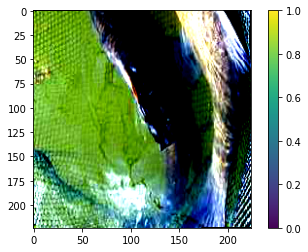

In [ ]:
train_data.__getitem__(0)[0].shape
test_img = np.transpose(train_data.__getitem__(0)[0].data.numpy(), (2,1,0))
plt.imshow(test_img)
plt.colorbar()

In [ ]:
# Import some progress bar utilities to keep track of training.
from tqdm.notebook import tqdm, trange
# from tqdm import tqdm


# Send the dataset objects to the data loader, which will generate batches of data used for training.
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### b. Use these data loaders to train and test a set of linear decoders. Each linear decoder should read out the final layer of one residual block in the network and output predictions for each of the Imagenette classes. You want to test the existing Courseptron representations, so make sure that all but the linear decoder parameters are frozen when you train.

In [ ]:
def test_model(model_ft):
    ## Testing
    correct = 0
    total = len(test_data)
    model_ft.eval() # set the model into evaluation mode, which changes the
    # behavior of the batch norm layer so that it is not sensitive to batch size
    with torch.no_grad():
        # Iterate through test set minibatchs
        for images, labels in tqdm(test_loader):
            # Forward pass
            inputs = images.to(device)
            labels = labels.to(device)
            y = model_ft(inputs)

            predictions = torch.argmax(y, dim=1)
            correct += torch.sum((predictions == labels).float())
    print('Test accuracy: {}'.format(correct/total))
    return correct/total
def train_model(model_ft, criterion, optimizer, num_epochs=25):
  acc_arr = []
  for epoch in trange(num_epochs):
        for images, labels in tqdm(train_loader):

            inputs = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Do the forward pass
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients and step
            loss.backward()
            optimizer.step()
        acc_arr.append(test_model(model_ft))
        model_ft.train()
  return max(acc_arr)

In [ ]:
# decoder funtion
def decoder(layer):
  fl = layer+1
  fc = layer+2
  courseptron_rb = courseptron[:fl]
  for param in courseptron_rb.parameters():
    param.requries_grad = False

  courseptron_rb.add_module(str(fl), nn.Flatten(start_dim= 1, end_dim= -1))
  # out = courseptron_rb(train_data.__getitem__(0)[0].unsqueeze(0).to(device))
  num_ftrs = courseptron_rb(train_data.__getitem__(0)[0].unsqueeze(0).to(device)).shape[1]
  courseptron_rb.add_module(str(fc), nn.Linear(num_ftrs, 10))
  model_ft = courseptron_rb.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
  best_acc = train_model(model_ft, criterion, optimizer, num_epochs=10)
  return best_acc

In [ ]:
rb_acc_arr = []
for layer in [4,5,6,7,9,10]:
  rb_acc = decoder(layer)
  rb_acc_arr.append(rb_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.40458595752716064


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.4575795829296112


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.49783435463905334


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.5577069520950317


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.49808913469314575


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.5712101459503174


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.547006368637085


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.5549044013023376


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.5635668635368347


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.4787260890007019


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.6914649605751038


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7192356586456299


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7388534545898438


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7696815133094788


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7556687593460083


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7727388143539429


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.800254762172699


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.775541365146637


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7625477313995361


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8142674565315247


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8267515301704407


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8761783242225647


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8828024864196777


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8886623978614807


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8929935693740845


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.89121013879776


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8991082310676575


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8993629813194275


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8863694071769714


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8988534808158875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9439489841461182


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9477706551551819


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9518470764160156


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9602547287940979


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9518470764160156


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9492993354797363


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9584712982177734


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9531209468841553


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9663693904876709


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9643311500549316


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8341400623321533


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8721018433570862


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8746496438980103


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8866241574287415


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8901910185813904


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.89095538854599


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8835668563842773


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8896814584732056


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.9011464715003967


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8873884677886963


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.740891695022583


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.775796115398407


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.7984712719917297


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8056050539016724


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.831847071647644


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8214012384414673


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8356687426567078


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8443311452865601


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8382165431976318


  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Test accuracy: 0.8343948721885681


### C. Log the classification accuracy of each linear decoder. Plot this accuracy to visualize how the decoder is performing as it readouts layers deeper into the network.

In [ ]:
rb_acc_arr

[tensor(0.5712, device='cuda:0'),
 tensor(0.8143, device='cuda:0'),
 tensor(0.8994, device='cuda:0'),
 tensor(0.9664, device='cuda:0'),
 tensor(0.9011, device='cuda:0'),
 tensor(0.8443, device='cuda:0')]

Text(0, 0.5, 'Accuracy')

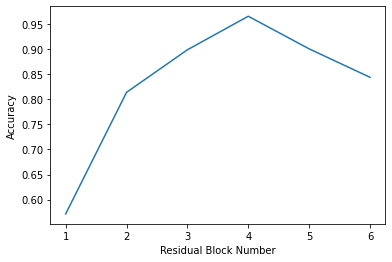

In [ ]:
rb_acc_arr_float = np.zeros(6)
for i in range(0,6):
  rb_acc_arr_float[i] = float(rb_acc_arr[i])

rbn = [1,2,3,4,5,6]
plt.plot(rbn, rb_acc_arr_float)
plt.xlabel("Residual Block Number")
plt.ylabel("Accuracy")

# 2. Support your results with dimensionality reduction

In [ ]:
test_data_2 = torch.utils.data.Subset(test_data, np.array([i for i in range(len(test_data)) if i%2!=0]))
test_loader_2 = torch.utils.data.DataLoader(test_data_2, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### a) Pass the Imagenett test images through the Courseptron network and extract the activations of all neurons in the residual block output layers you decoded from in Part 1.

In [ ]:
def test_model_2(model_ft):
    ## Testing
    correct = 0
    total = len(test_data)
    model_ft.eval() # set the model into evaluation mode, which changes the
    # behavior of the batch norm layer so that it is not sensitive to batch size
    with torch.no_grad():
        # Iterate through test set minibatchs
        for images, labels in tqdm(test_loader):
            # Forward pass
            inputs = images.to(device)
            labels = labels.to(device)
            y = model_ft(inputs)

            predictions = torch.argmax(y, dim=1)
            correct += torch.sum((predictions == labels).float())
    print('Test accuracy: {}'.format(correct/total))

def train_model_2(model_ft, criterion, optimizer, num_epochs=25):
  for epoch in trange(num_epochs):
        for images, labels in tqdm(train_loader):

            inputs = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Do the forward pass
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients and step
            loss.backward()
            optimizer.step()
        test_model_2(model_ft)
        model_ft.train()

def activation(model, classes):
  activ = []
  y = []
  for param in model.parameters():
    param.requries_grad = False

  with torch.no_grad():
    # Iterate through test set minibatchs
    for images, labels in tqdm(test_loader_2):
      if labels == classes[0] or labels == classes[1] or labels == classes[2]:
        # Forward pass
        inputs = images.to(device)
        outputs = model(inputs).detach().cpu().numpy()
        lbs = labels.detach().cpu().numpy()
        y.append(lbs)
        activ.append(outputs)

  return np.concatenate(y), np.concatenate(activ)

def decoder_activation(layer, classes):
  fl = layer+1
  fc = layer+2
  courseptron_rb = courseptron[:fl]
  for param in courseptron_rb.parameters():
    param.requries_grad = False

  model_ft = courseptron_rb.to(device)

  [target, activ] = activation(model_ft, classes)

  return target, activ.reshape(activ.shape[0], activ.shape[1]*activ.shape[2]*activ.shape[3])

In [ ]:
target_4, activation_4 = decoder_activation(4, torch.as_tensor([[0], [4], [9]]))
target_5, activation_5 = decoder_activation(5, torch.as_tensor([[0], [4], [9]]))
target_6, activation_6 = decoder_activation(6, torch.as_tensor([[0], [4], [9]]))
target_7, activation_7 = decoder_activation(7, torch.as_tensor([[0], [4], [9]]))
target_9, activation_9 = decoder_activation(9, torch.as_tensor([[0], [4], [9]]))
target_10, activation_10 = decoder_activation(10, torch.as_tensor([[0], [4], [9]]))
# activation_4

  0%|          | 0/1962 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1962 [00:00<?, ?it/s]

  0%|          | 0/1962 [00:00<?, ?it/s]

  0%|          | 0/1962 [00:00<?, ?it/s]

  0%|          | 0/1962 [00:00<?, ?it/s]

  0%|          | 0/1962 [00:00<?, ?it/s]

In [ ]:
activation_4.shape

(593, 200704)

### b) Take the population responses for all images in 3 of the 10 Imagenette classes and use PCA and LDA to embed them into a 2-dimensional space. For earlier layers, where the layers have larger spatial dimensions, you may need to take every other image from each of these 3 classes, in order to avoid Colab memory errors.

### c) Make scatter plots of the resulting 2-dimensional points, and color-code each point according to its class.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

<Figure size 432x288 with 0 Axes>

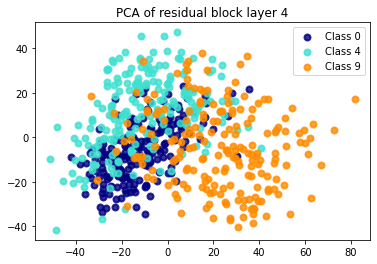

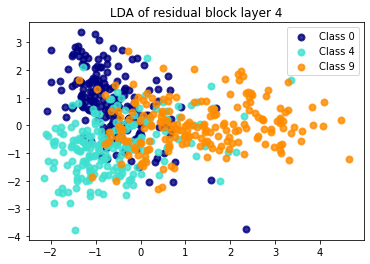

In [ ]:
target_names = ['Class 0', 'Class 4', 'Class 9']
pca = PCA(n_components=2)
pop_response_4 = pca.fit(activation_4).transform(activation_4)

lda = LDA(n_components=2)
pop_response_4_lda = lda.fit(activation_4, target_4).transform(activation_4)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
  plt.scatter(
        pop_response_4[target_4==i, 0], pop_response_4[target_4==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of residual block layer 4")

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
    plt.scatter(
        pop_response_4_lda[target_4==i, 0], pop_response_4_lda[target_4==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of residual block layer 4")

plt.show()


<Figure size 432x288 with 0 Axes>

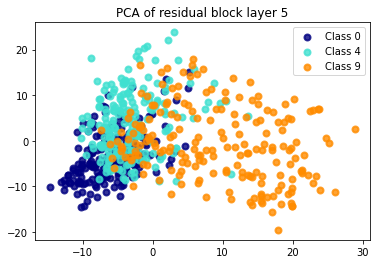

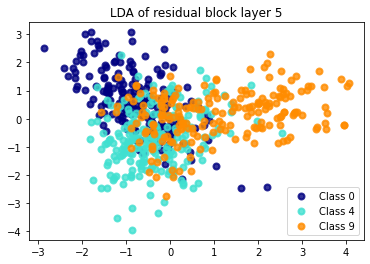

In [ ]:
target_names = ['Class 0', 'Class 4', 'Class 9']
pca = PCA(n_components=2)
pop_response_5 = pca.fit(activation_5).transform(activation_5)

lda = LDA(n_components=2)
pop_response_5_lda = lda.fit(activation_5, target_5).transform(activation_5)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
  plt.scatter(
        pop_response_5[target_5==i, 0], pop_response_5[target_5==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of residual block layer 5")

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
    plt.scatter(
        pop_response_5_lda[target_5==i, 0], pop_response_5_lda[target_5==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of residual block layer 5")

plt.show()

<Figure size 432x288 with 0 Axes>

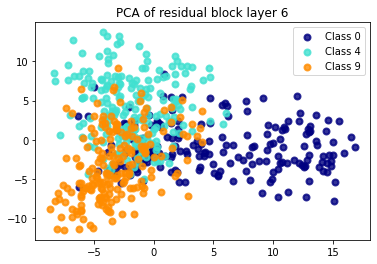

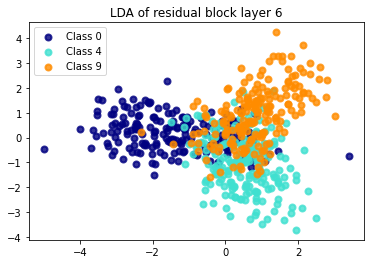

In [ ]:
target_names = ['Class 0', 'Class 4', 'Class 9']
pca = PCA(n_components=2)
pop_response_6 = pca.fit(activation_6).transform(activation_6)

lda = LDA(n_components=2)
pop_response_6_lda = lda.fit(activation_6, target_6).transform(activation_6)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
  plt.scatter(
        pop_response_6[target_6==i, 0], pop_response_6[target_6==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of residual block layer 6")

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
    plt.scatter(
        pop_response_6_lda[target_6==i, 0], pop_response_6_lda[target_6==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of residual block layer 6")

plt.show()

<Figure size 432x288 with 0 Axes>

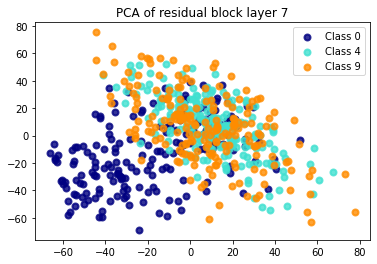

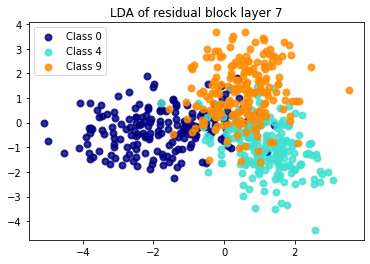

In [ ]:
target_names = ['Class 0', 'Class 4', 'Class 9']
pca = PCA(n_components=2)
pop_response_7 = pca.fit(activation_7).transform(activation_7)

lda = LDA(n_components=2)
pop_response_7_lda = lda.fit(activation_7, target_7).transform(activation_7)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
  plt.scatter(
        pop_response_7[target_7==i, 0], pop_response_7[target_7==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of residual block layer 7")

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
    plt.scatter(
        pop_response_7_lda[target_7==i, 0], pop_response_7_lda[target_7==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of residual block layer 7")

plt.show()

<Figure size 432x288 with 0 Axes>

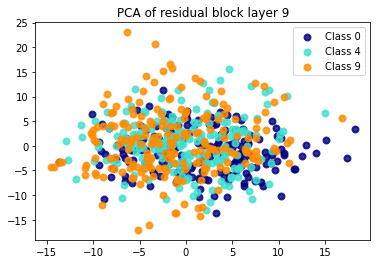

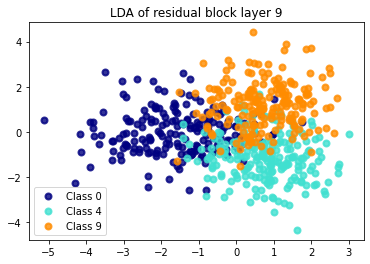

In [ ]:
target_names = ['Class 0', 'Class 4', 'Class 9']
pca = PCA(n_components=2)
pop_response_9 = pca.fit(activation_9).transform(activation_9)

lda = LDA(n_components=2)
pop_response_9_lda = lda.fit(activation_9, target_9).transform(activation_9)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
  plt.scatter(
        pop_response_9[target_9==i, 0], pop_response_9[target_9==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of residual block layer 9")

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
    plt.scatter(
        pop_response_9_lda[target_9==i, 0], pop_response_9_lda[target_9==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of residual block layer 9")

plt.show()

<Figure size 432x288 with 0 Axes>

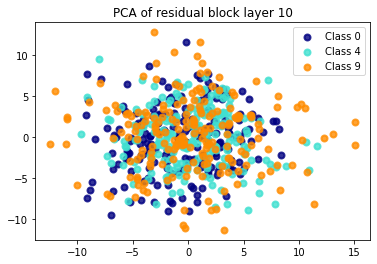

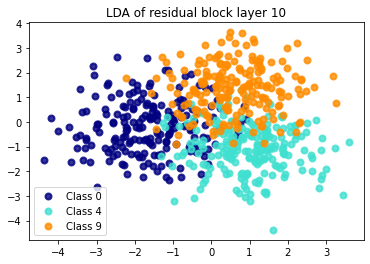

In [ ]:
target_names = ['Class 0', 'Class 4', 'Class 9']
pca = PCA(n_components=2)
pop_response_10 = pca.fit(activation_10).transform(activation_10)

lda = LDA(n_components=2)
pop_response_10_lda = lda.fit(activation_10, target_10).transform(activation_10)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
  plt.scatter(
        pop_response_10[target_10==i, 0], pop_response_10[target_10==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of residual block layer 10")

plt.figure()
for color, i, target_name in zip(colors, [0,4,9], target_names):
    plt.scatter(
        pop_response_10_lda[target_10==i, 0], pop_response_10_lda[target_10==i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of residual block layer 10")

plt.show()

What do you observe from the PCA and LDA scatter plots? Do they change as you go deeper into the network,? If so, how? Discuss the properties of PCA and LDA that enable your observations. Do the PCA results look like the LDA results? If not, why are they different? Discuss how these plots support your results from Part 1.

As the network goes deeper, LDA deals with the classification increasingly better, while the PCA deals with the classification badly except in residual block 6.

The PCA results look different from the LDA results. This makes sense because they reduce dimensionality in different ways. PCA reduces dimensionality and helps visualizing classes by translating the variables into a new collection of components such that PC1 maximizes the variance, followed by PC2, PC3.. (i.e. PC1 > PC2 > PC3 > … and so forth). On the other hand, LDA  is a technique of supervised machine learning, which optimize the separability between the two classes to identify them in the best way we can determine. Different from unsupervised PCA, LDA does not function on finding the primary variable; it merely looks at what kind of point/features/subspace to distinguish the data offers further discrimination. Therefore, LDA still works fine even when PCA fails to find principle axes that maximize the variance and helps visulizing the classification.

These plots support my results from part 1. Based on part 1, the classification accuracies are high in residual block number 3, 4, and 5, which correspond to layer 6, 7, and 9, respectively. In this part, we can see that the LDA gives the best classifications in those blocks.

# 3. Report your results to Serac

Which layer is the best candidate for being Courseptron's IT homologue? Briefly summarize your justification.

Layer 7 (residual block #4) is the best candiate for being Courseptron's IT homologue because 1) based on part 1, it gives the highest accuracy, and 2) based on part 1, it gives one of the best visualization of classes.